In [24]:
from src.experiment import ExperimentInstance
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import tensorflow as tf
import random
import shap
import ipywidgets as widgets
import re
from src.model import binary_sigmoid_unit

In [55]:
def plot_selection_mask(features, selected_features, features_list, dataset="", plot=True):
    selection_masks = []
    for feat in features_list:
        
        feats = features[np.core.defchararray.find(features, feat)!=-1]
        if len(feats)==0:
            continue
        sfeats = selected_features[np.core.defchararray.find(selected_features, feat)!=-1]

        
        mask = np.isin(feats, sfeats).astype(np.uint)
        selection_masks.append(mask)

    selection_masks = np.stack(selection_masks)

    if plot:
        fig, ax = plt.subplots(figsize=(30,10))

        ax.set_title(f'Selected features in {dataset} ({round(selection_masks.sum()/(selection_masks.shape[0]*selection_masks.shape[1]), 2)}%)')
        cmap = sns.cm.crest_r
        feats[-2::-2] = ''
        g = sns.heatmap(selection_masks, yticklabels=list(map(lambda x: x.upper(), features_list)),cmap=cmap, xticklabels=list(map(lambda f: f.replace('target_o3 t', ''), feats.tolist())), cbar=False, linewidth=.5, ax=ax)
        plt.xticks(rotation=45)
        plt.show()

    return selection_masks

In [70]:
dataset = 'Raif'

best_hyperparameters = pd.read_csv("results/ResSelNet/params/best_params.csv")

from collections import defaultdict
import re

top_elements = ["model", "selection", "dataset"]
replacements = {"TSL": "TimeSelectionLayer", "TFF": "dense", "TLSTM": "lstm", "FF": "dense", "LSTM":"lstm", "NS": "NoSelection"}

def update_config(elements, new_config):
    for k, v in elements.items():
        if type(v)==str:
            for ori, dst in replacements.items():
                v = v.replace(ori, dst)

        values = k.split("_")

        if values[0] in top_elements:
            if values[1] == "params":
                new_config[values[0]][values[1]].update({'_'.join(values[2:]): v})
            elif values[1] == "name":
                new_config[values[0]][values[1]] = v

    return new_config

def transform_to_config(config):

    new_config = defaultdict(lambda : defaultdict(dict))
    
    new_config = update_config(eval(config.params), new_config)
    new_config = update_config(config, new_config)
    
    return dict(new_config)

best_hyperparameters["dataset_name"] = best_hyperparameters["dataset"]
parameters = best_hyperparameters.set_index("dataset")[best_hyperparameters.set_index("dataset").model_name=="TFF"][["params", "selection_name", "dataset_params_seq_len", "dataset_params_crossval", "dataset_params_shift","dataset_params_pred_len", "selection_params_residual","dataset_name", "selection_name", "model_name"]].apply(transform_to_config, axis=1).to_dict()

In [48]:
seed = 123
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)
experiment = ExperimentInstance(parameters[dataset])
experiment.run()

{'dataset': {'name': 'Raif', 'params': {'seq_len': 2, 'pred_len': 1, 'shift': 1, 'crossval': False}}, 'selection': {'name': 'TimeSelectionLayer', 'params': {'regularization': 0.0099732287722297, 'residual': True}}, 'model': {'name': 'dense', 'params': {'layers': 2, 'units': 12, 'batch_size': 85, 'lr': 0.0069398794834175, 'dropout': 0.0079106214232781, 'type': 'tensorflow'}}}
413
413
28
28
52
52
1/1 [==============================] - 0s 14ms/step


,mean_squared_error,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,r2,mean_absolute_error_valid,root_mean_squared_error_valid,mean_squared_error_valid,dataset,dataset_name,...,model_params_batch_size,model_params_lr,model_params_dropout,model_params_type,features,selected_features,duration,history,val_loss,code
0,3.810786,1.952124,1.420211,5.476029e+14,0.415877,1.520041,2.411309,5.814411,Raif,Raif,...,85,0.00694,0.007911,tensorflow,"[02DensidadPlantasha t-2, 110FenologaHEndureci...","[CV4 t-1, target_moscamosquero t-1, 406MoscaAc...",4.619836,"[5.037522792816162, 4.574882984161377, 4.58507...",2.208356,eb48bc38babaf0cd3000ae4e6e85e654


In [38]:
experiment.model.summary()

Model: "tsmodel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 50)]         0           []                               
                                                                                                  
 inputs_reshaped (Reshape)      (None, 2, 25)        0           ['inputs[0][0]']                 
                                                                                                  
 sequential_6 (Sequential)      (None, 50)           50          ['inputs_reshaped[0][0]']        
                                                                                                  
 layer0 (Dense)                 (None, 12)           612         ['sequential_6[0][0]']           
                                                                                            

In [39]:
features = np.array(experiment.metrics.features.tolist()[0])

In [40]:
def get_selected_idxs(model, features):
    selected_idxs = {}
    for layer in model.layers:
        if 'selection' in layer.name:
            mask = binary_sigmoid_unit(layer.get_mask()).numpy()
            selected_idxs[layer.name] = features[
                mask.flatten().astype(bool)].tolist()
        elif type(layer) == tf.keras.Sequential:
            selected_idxs.update(get_selected_idxs(layer, features))
    
    return selected_idxs

In [41]:
len(features)

50

In [45]:
selected_features_per_layer = get_selected_idxs(experiment.model, features)

In [43]:
selected_features_per_layer

{'selection_0': ['HRMed t-1', 'target_moscamosquero t-1'],
 'selection_2': ['CV4 t-1'],
 'selection_3': ['406MoscaAceitunasPicadasTotal t-2']}

In [34]:
features_without_t = list(set(map(lambda x: re.sub(r" t-\d+", "", x), features))) 

In [56]:
selection_mask(features, np.array(selected_features_per_layer["selection_0"]), features_without_t)

ValueError: all input arrays must have the same shape

0.3660130718954248


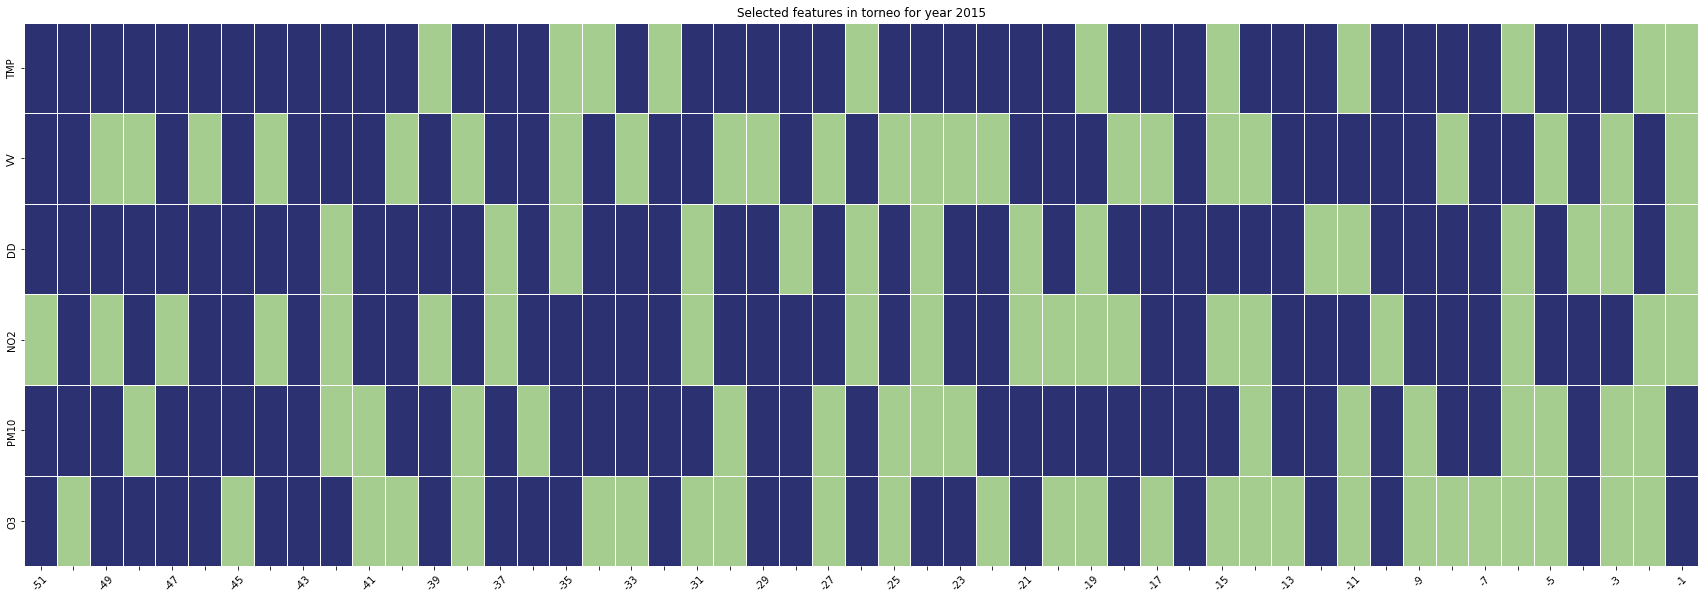

In [48]:
plot_selection_mask(features, np.array(selected_features_per_layer["selection_out"]), features_list)

In [37]:
len(selected_features_per_layer["selection_in"])

76

In [36]:
len(selected_features_per_layer["selection_out"])

112

## Error maps

In [6]:
inputs, true, preds = experiment.raw_results_[-1]

explainer = shap.Explainer(experiment.model, shap.kmeans(experiment.data_train[0], 100))
shap_values = explainer(inputs, max_evals=1000)

preds = preds.reshape(-1, 3)
true = true.reshape(-1, 3)

list_of_labels = ["ET0 t+1", "ET0 t+2", "ET0 t+3"]

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(
    options=tuple_of_labels, value=0, description="Select Label:"
)

# Display the dropdown list (Note: access index value with 'current_label.value')
shap.initjs()


ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
current_label

print(f"Current Label Shown: {list_of_labels[current_label.value]}\n")

shap_values = explainer.shap_values(X=inputs)

shap.summary_plot(
    shap_values=shap_values[:, :, current_label.value], features=inputs   
)

In [23]:
current_label.value

0

In [22]:
inputs.shape

(114, 390)

In [21]:
shap_values.shape

(114, 390, 3)

In [29]:
dataset = 'asomadilla'
"""with open(f'results/OzoneCrossVal/predictions/{dataset}_true.npy', 'wb') as f:
    np.save(f, true)

with open(f'results/OzoneCrossVal/predictions/{dataset}_preds.npy', 'wb') as f:
    np.save(f, preds)"""

dates = pd.date_range(datetime(2015, 1, 1) + timedelta(hours=24+1), datetime(2016, 1, 1), freq='H')
dates = dates[:len(true)]

mse = (true-preds)**2
results = pd.DataFrame({'Month': dates.month, 'Hour': dates.hour, 'Error': mse}).iloc[:-1].groupby(['Month', 'Hour']).mean().reset_index()
heatmap = results.pivot("Hour", "Month", "Error").apply(np.sqrt)

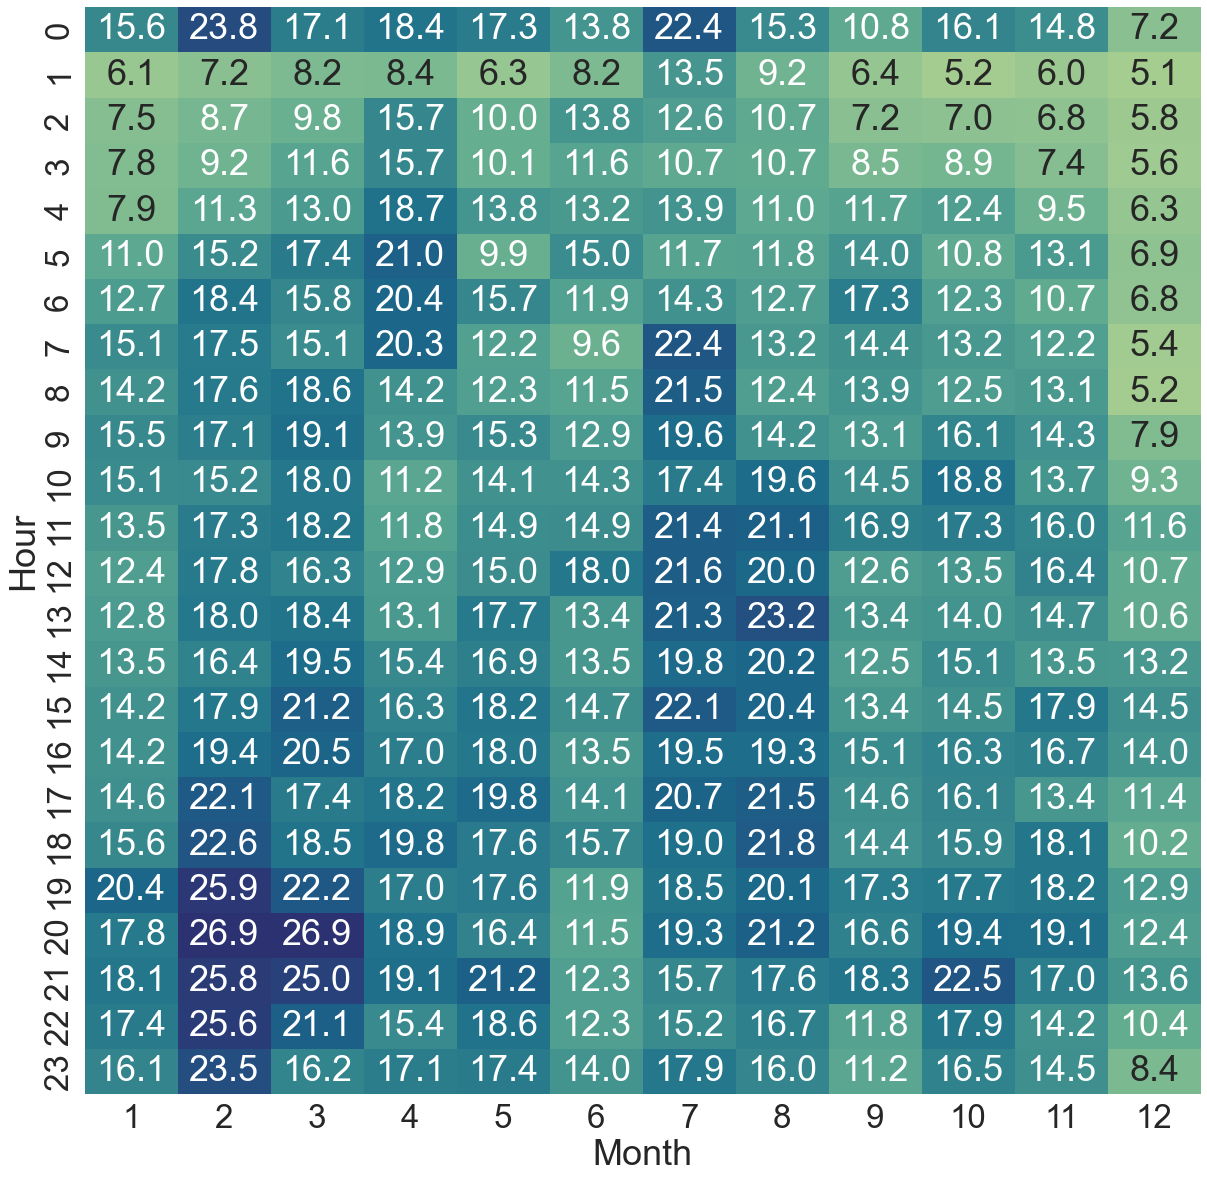

In [30]:
sns.set(font_scale=3)
plt.subplots(figsize=(20,20))
g = sns.heatmap(heatmap, annot=True, cmap="crest", fmt=".1f", cbar=False)
fig = g.get_figure()
fig.savefig(f"figures/ErrorMaps/{dataset.capitalize()}TSL.png", bbox_inches='tight') 

## Best/Worst predictions

In [7]:
preds = preds.reshape(-1, 24)
true = true.reshape(-1, 24)
mse_reshaped = np.sqrt(((true-preds)**2).mean(axis=1))
min_index = np.argmin(mse_reshaped)
best_dates = dates[min_index*24: min_index*24+24]
best_preds = preds[min_index]
best_trues = true[min_index]

max_index = np.argmax(mse_reshaped)

worst_dates = dates[max_index*24: max_index*24+24]
worst_preds = preds[max_index]
worst_trues = true[max_index]

In [8]:
"""sns.set(style='white', font_scale=2.4)
fig, ax = plt.subplots(2, 1, figsize=(20,10))
sns.lineplot(x=best_dates, y=best_preds, ax=ax[0], label='Prediction', marker='o')
sns.lineplot(x=best_dates, y=best_trues, ax=ax[0], label='True', marker='o')
ax[0].xaxis.grid() # vertical lines
ax[0].set_title(f'Best prediction ({round(mse_reshaped[min_index], 2)} RMSE)')
ax[0].fill_between(best_dates, best_preds, best_trues, where=(best_preds > best_trues), color='C0', alpha=0.2, interpolate=True)
ax[0].fill_between(best_dates, best_preds, best_trues, where=(best_preds <= best_trues), color='C1', alpha=0.2, interpolate=True)


sns.lineplot(x=worst_dates, y=worst_preds, ax=ax[1], label='Prediction', marker='o')
sns.lineplot(x=worst_dates, y=worst_trues, ax=ax[1], label='True', marker='o')
ax[1].xaxis.grid() # vertical lines
ax[1].set_title(f'Worst prediction ({round(mse_reshaped[max_index], 2)} RMSE)')
ax[1].fill_between(worst_dates, worst_preds, worst_trues, where=(worst_preds <= worst_trues), color='C1', alpha=0.2, interpolate=True)
ax[1].fill_between(worst_dates, worst_preds, worst_trues, where=(worst_preds > worst_trues), color='C0', alpha=0.2, interpolate=True)


date_form = DateFormatter("%d %b %H:00")
ax[0].xaxis.set_major_formatter(date_form)

ax[1].xaxis.set_major_formatter(date_form)


for label in ax[0].get_xticklabels():
    label.set_ha("center")
    label.set_rotation(25)

for label in ax[1].get_xticklabels():
    label.set_ha("center")
    label.set_rotation(25)

plt.tight_layout()

fig.savefig(f"figures/BestWorst/BestWorst{dataset.capitalize()}TSL.png", bbox_inches='tight') """

'sns.set(style=\'white\', font_scale=2.4)\nfig, ax = plt.subplots(2, 1, figsize=(20,10))\nsns.lineplot(x=best_dates, y=best_preds, ax=ax[0], label=\'Prediction\', marker=\'o\')\nsns.lineplot(x=best_dates, y=best_trues, ax=ax[0], label=\'True\', marker=\'o\')\nax[0].xaxis.grid() # vertical lines\nax[0].set_title(f\'Best prediction ({round(mse_reshaped[min_index], 2)} RMSE)\')\nax[0].fill_between(best_dates, best_preds, best_trues, where=(best_preds > best_trues), color=\'C0\', alpha=0.2, interpolate=True)\nax[0].fill_between(best_dates, best_preds, best_trues, where=(best_preds <= best_trues), color=\'C1\', alpha=0.2, interpolate=True)\n\n\nsns.lineplot(x=worst_dates, y=worst_preds, ax=ax[1], label=\'Prediction\', marker=\'o\')\nsns.lineplot(x=worst_dates, y=worst_trues, ax=ax[1], label=\'True\', marker=\'o\')\nax[1].xaxis.grid() # vertical lines\nax[1].set_title(f\'Worst prediction ({round(mse_reshaped[max_index], 2)} RMSE)\')\nax[1].fill_between(worst_dates, worst_preds, worst_trues, 